# Clustering Algorithms - Overview

Both clustering and dimensionality reduction summarize the data. Dimensionality reduction compresses the data by representing it using new, fewer features that capture the most relevant information. Clustering algorithms, in contrast, assign existing observations to subgroups that consist of similar data points.

Clustering can serve to better understand the data through the lens of categories learned from continuous variables. It also permits automatically categorizing new objects according to the learned criteria. Examples of related applications include hierarchical taxonomies, medical diagnostics, or customer segmentation. Alternatively, clusters can be used to represent groups as prototypes, using e.g. the midpoint of a cluster as the best representatives of learned grouping. An example application includes image compression.

Clustering algorithms differ with respect to their strategy of identifying groupings:
- Combinatorial algorithms select the most coherent of different groupings of observations
- Probabilistic modeling estimates distributions that most likely generated the clusters
- Hierarchical clustering finds a sequence of nested clusters that optimizes coherence at any given stage

Algorithms also differ by the notion of what constitutes a useful collection of objects that needs to match the data characteristics, domain and the goal of the applications. Types of groupings include:
- Clearly separated groups of various shapes
- Prototype- or center-based, compact clusters
- Density-based clusters of arbitrary shape
- Connectivity- or graph-based clusters


Important additional aspects of a clustering algorithm include whether 
- it requires exclusive cluster membership, 
- makes hard, i.e., binary, or soft, probabilistic assignment, and 
- is complete and assigns all data points to clusters.

This notebook compares several clustering algorithms using toy datasets.

## Imports & Settings

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import rand, seed
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.datasets import make_blobs, make_circles, make_moons
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns

In [3]:
sns.set_style('white')
seed(42)

In [4]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
cmap = ListedColormap(sns.color_palette(flatui))

## Generate Synthetic Datasets

In [5]:
n_samples = 1500
random_state = 170

In [6]:
blobs = make_blobs(n_samples=n_samples, 
                   random_state=random_state)

In [7]:
noisy_circles = make_circles(n_samples=n_samples, 
                             factor=.5, 
                             noise=.05)

In [8]:
noisy_moons = make_moons(n_samples=n_samples, 
                         noise=.05)

In [9]:
uniform = rand(n_samples, 2), None

In [10]:
X, y = make_blobs(n_samples=n_samples, 
                  random_state=random_state)

In [11]:
elongated = X.dot([[0.6, -0.6], [-0.4, 0.8]]), y

In [12]:
varied = make_blobs(n_samples=n_samples,
                    cluster_std=[1.0, 2.5, 0.5],
                    random_state=random_state)

In [13]:
default_params = {'quantile': .3,
                  'eps': .2,
                  'damping': .9,
                  'preference': -200,
                  'n_neighbors': 10,
                  'n_clusters': 3}

In [14]:
datasets = [('Standard Normal', blobs, {}),
            ('Various Normal', varied, {'eps': .18, 'n_neighbors': 2}),
            ('Anisotropic Normal', elongated, {'eps': .15, 'n_neighbors': 2}),
            ('Uniform', uniform, {}),
            ('Circles', noisy_circles, {'damping': .77, 'preference': -240,
                                        'quantile': .2, 'n_clusters': 2}),
            ('Moons', noisy_moons, {'damping': .75,
                                    'preference': -220, 'n_clusters': 2})]

## Plot Cluster Algorithm Results

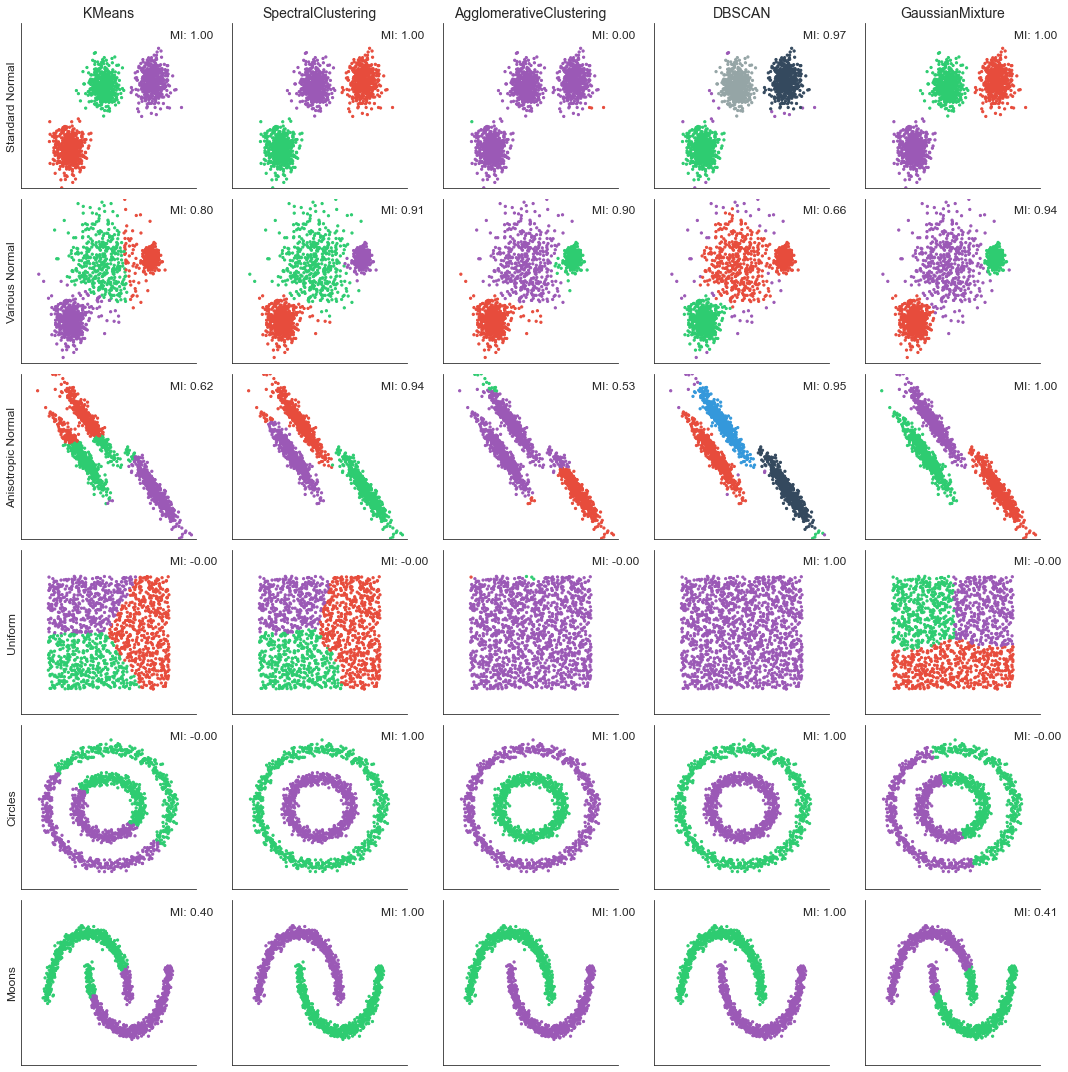

In [15]:
fig, axes = plt.subplots(figsize=(15, 15),
                         ncols=5,
                         nrows=len(datasets),
                         sharey=True,
                         sharex=True)

plt.setp(axes, xticks=[], yticks=[], xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))

for d, (dataset_label, dataset, algo_params) in enumerate(datasets):
    params = default_params.copy()
    params.update(algo_params)

    X, y = dataset
    X = StandardScaler().fit_transform(X)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'],
                                    include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)

    kmeans = KMeans(n_clusters=params['n_clusters'])

    spectral = SpectralClustering(n_clusters=params['n_clusters'],
                                  eigen_solver='arpack',
                                  affinity='nearest_neighbors')

    dbscan = DBSCAN(eps=params['eps'])
    average_linkage = AgglomerativeClustering(linkage="average",
                                              affinity="cityblock",
                                              n_clusters=params['n_clusters'],
                                              connectivity=connectivity)

    gmm = GaussianMixture(n_components=params['n_clusters'],
                          covariance_type='full')

    clustering_algorithms = (('KMeans', kmeans),
                             ('SpectralClustering', spectral),
                             ('AgglomerativeClustering', average_linkage),
                             ('DBSCAN', dbscan),
                             ('GaussianMixture', gmm))

    for a, (name, algorithm) in enumerate(clustering_algorithms):

        if name == 'GaussianMixture':
            algorithm.fit(X)
            y_pred = algorithm.predict(X)
        else:
            y_pred = algorithm.fit_predict(X)

        axes[d, a].scatter(X[:, 0], 
                           X[:, 1], 
                           s=5, 
                           c=y_pred, 
                           cmap=cmap)
        
        if d == 0:
            axes[d, a].set_title(name, size=14)
        if a == 0:
            axes[d, a].set_ylabel(dataset_label, size=12)

        if y is None:
            y = [.5] * n_samples
        mi = adjusted_mutual_info_score(labels_pred=y_pred, 
                                        labels_true=y)
        axes[d, a].text(0.85, 0.91, 
                        f'MI: {mi:.2f}', 
                        transform=axes[d, a].transAxes, 
                        fontsize=12)
        axes[d, a].axes.get_xaxis().set_visible(False)

sns.despine()
fig.tight_layout()